In [1]:
% matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
from tensorflow.python.ops import clip_ops
from bn_class import *
import json
import requests
import csv

/Users/mshegde/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
"""Hyperparameters"""
num_filt_1 = 15     #Number of filters in first conv layer
num_filt_2 = 8      #Number of filters in second conv layer
num_filt_3 = 8      #Number of filters in thirs conv layer
num_fc_1 = 1024     #Number of neurons in fully connected layer
max_iterations = 8000
model_num=7         #Number of model used for voting
voting_times=3      #Threshold of voting
batch_size = 100
dropout = 0.5       #Dropout rate in the fully connected layer
plot_row = 5        #How many rows do you want to plot in the visualization
regularization = 1e-4
learning_rate = 2e-3
input_norm = False   # Do you want z-score input normalization?
np.set_printoptions(threshold=np.inf)#print full array

In [11]:
data_train = []
data_test = []
symbol = "TATACOMM"
fileReadTrain = open("Final/Train_set_"+symbol+".csv")
readerTrain = csv.reader(fileReadTrain)
fileReadTest = open("Final/Test_set_"+symbol+".csv")
readerTest = csv.reader(fileReadTest)
for rowTrain in readerTrain:
    labelTrain = rowTrain[0]
    closePriceTrain = rowTrain[2]
    data_train.append([labelTrain,closePriceTrain])
for rowTest in readerTest:
    labelTest = rowTest[0]
    closePriceTest = rowTest[2]
    data_test.append([labelTest,closePriceTest])
data_train = np.array(data_train)
print(data_train)
data_test = np.array(data_test)
print(data_test)

[['0' '840.00']
 ['0' '843.00']
 ['0' '847.00']
 ['0' '857.00']
 ['0' '845.00']
 ['0' '877.50']
 ['0' '915.00']
 ['0' '925.00']
 ['0' '910.00']
 ['0' '941.00']
 ['0' '1025.00']
 ['0' '1048.00']
 ['0' '1050.00']
 ['0' '1048.00']
 ['0' '1058.00']
 ['0' '1050.00']
 ['0' '1050.00']
 ['0' '1063.00']
 ['0' '1010.00']
 ['0' '1013.00']
 ['0' '1055.00']
 ['0' '1055.00']
 ['0' '1000.00']
 ['0' '1000.00']
 ['0' '1065.00']
 ['0' '1100.00']
 ['0' '1213.35']
 ['0' '1210.00']
 ['0' '1240.00']
 ['0' '1300.00']
 ['0' '1200.00']
 ['0' '1225.00']
 ['0' '1275.00']
 ['0' '1345.00']
 ['0' '1305.00']
 ['0' '1253.00']
 ['0' '1250.20']
 ['0' '1450.00']
 ['0' '1450.00']
 ['0' '1440.00']
 ['0' '1450.00']
 ['0' '1350.00']
 ['0' '1300.00']
 ['0' '1300.00']
 ['0' '1350.00']
 ['0' '1400.00']
 ['0' '1430.00']
 ['0' '1375.00']
 ['0' '1250.00']
 ['0' '1150.00']
 ['0' '1275.00']
 ['0' '1165.00']
 ['0' '1165.00']
 ['0' '1150.00']
 ['0' '1165.00']
 ['0' '1090.00']
 ['1' '1000.00']
 ['1' '930.00']
 ['1' '960.00']
 ['1' '90

## split training and testing data

In [12]:
X_train = data_train[:,1:]
X_train = np.asarray(X_train, dtype=float)
#print("X_train:",X_train)
X_test = data_test[:,1:]
print(X_test)
print(X_test.shape)
X_test = np.asarray(X_test, dtype=float)
N = X_train.shape[0]
Ntest = X_test.shape[0]
D = X_train.shape[1]
y_train = data_train[:,0]
y_train = np.asarray(y_train, dtype=int)
y_test = data_test[:,0]
y_test = np.asarray(y_test, dtype=float)

[['292.80']
 ['287.90']
 ['290.00']
 ['285.50']
 ['279.60']
 ['279.80']
 ['274.35']
 ['271.40']
 ['267.75']
 ['278.80']
 ['278.15']
 ['278.05']
 ['295.70']
 ['290.60']
 ['297.05']
 ['295.65']
 ['300.70']
 ['298.80']
 ['311.30']
 ['309.05']
 ['299.75']
 ['310.00']
 ['317.30']
 ['312.50']
 ['312.00']
 ['303.10']
 ['302.05']
 ['306.40']
 ['305.50']
 ['304.00']
 ['294.05']
 ['295.10']
 ['301.00']
 ['308.40']
 ['309.70']
 ['304.00']
 ['293.80']
 ['274.80']
 ['275.50']
 ['276.00']
 ['272.75']
 ['274.95']
 ['258.50']
 ['272.00']
 ['278.40']
 ['300.00']
 ['294.45']
 ['293.90']
 ['299.00']
 ['304.00']
 ['293.00']
 ['285.40']
 ['279.90']
 ['279.35']
 ['272.05']
 ['273.00']
 ['272.05']
 ['273.05']
 ['279.75']
 ['280.30']
 ['279.80']
 ['274.50']
 ['290.60']
 ['286.40']
 ['293.70']
 ['285.70']
 ['288.00']
 ['281.70']
 ['288.70']
 ['281.50']
 ['285.00']
 ['283.90']
 ['288.00']
 ['287.25']
 ['285.95']
 ['285.50']
 ['286.95']
 ['285.90']
 ['291.40']
 ['299.90']
 ['303.00']
 ['304.85']
 ['303.80']
 ['3

## normalize x and y

In [13]:
num_classes = len(np.unique(y_train))
base = min(y_train)  #Check if data is 0-based
if base != 0:
    y_train -=base
    y_test -= base

if input_norm:
    mean = np.mean(X_train,axis=0)
    print(mean)
    variance = np.var(X_train,axis=0)
    print(variance)
    X_train -= mean
    X_train /= np.sqrt(variance)+1e-9
    X_test -= mean
    X_test /= np.sqrt(variance)+1e-9

In [14]:
epochs = np.floor(batch_size*max_iterations / N)
print('Train with approximately %d epochs' %(epochs))

Train with approximately 195 epochs


## place for the input variables

In [15]:
total_rst=np.zeros((model_num,len(y_test)), dtype=np.float)
print(total_rst)
def getStockPrices(symbol):
    url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol='+symbol+'&outputsize=full&apikey=8D61YMWXRIO85QT3'
    response = requests.get(url)
    return response.json()
def getData(symbol):
	stocksDaily = getStockPrices(symbol)["Time Series (Daily)"]
	stocksDates = stocksDaily.keys()
	Labels = ["Date","open","high","low","close","volume"]
	stock_data = []
	for i in stocksDates:
		dailyStock = stocksDaily[i]
		openPrice = dailyStock["1. open"]
		highPrice = dailyStock["2. high"]
		lowPrice = dailyStock["3. low"]
		closePrice = dailyStock["4. close"]
		volume = dailyStock["5. volume"]
		stock_data_i = {"Date":i,"Open":openPrice,"High":highPrice,"Low":lowPrice,"Close":closePrice,"Volume":volume}
		stock_data.append(stock_data_i)
	return stock_data[:500]


for xx in range(0,model_num):
  print("Training at model "+str(xx))
  x = tf.placeholder("float", shape=[None, D], name = 'Input_data')
  y_ = tf.placeholder(tf.int64, shape=[None], name = 'Ground_truth')
  keep_prob = tf.placeholder("float")
  bn_train = tf.placeholder(tf.bool)          #Boolean value to guide batchnorm

  ## w and b and conv function
  def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name = name)

  def bias_variable(shape, name):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name = name)

  def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

  def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

  with tf.name_scope("Reshaping_data") as scope:
    x_image = tf.reshape(x, [-1,D,1,1])

  ## Build the graph
  # ewma is the decay for which we update the moving average of the 
  # mean and variance in the batch-norm layers
  with tf.name_scope("Conv1") as scope:
    W_conv1 = weight_variable([4, 1, 1, num_filt_1], 'Conv_Layer_1')
    b_conv1 = bias_variable([num_filt_1], 'bias_for_Conv_Layer_1')
    a_conv1 = conv2d(x_image, W_conv1) + b_conv1
    
  with tf.name_scope('Batch_norm_conv1') as scope:
      ewma = tf.train.ExponentialMovingAverage(decay=0.99)                  
      bn_conv1 = ConvolutionalBatchNormalizer(num_filt_1, 0.001, ewma, True)           
      update_assignments = bn_conv1.get_assigner() 
      a_conv1 = bn_conv1.normalize(a_conv1, train=bn_train) 
      h_conv1 = tf.nn.relu(a_conv1)
    
  with tf.name_scope("Conv2") as scope:
    W_conv2 = weight_variable([4, 1, num_filt_1, num_filt_2], 'Conv_Layer_2')
    b_conv2 = bias_variable([num_filt_2], 'bias_for_Conv_Layer_2')
    a_conv2 = conv2d(h_conv1, W_conv2) + b_conv2
    
  with tf.name_scope('Batch_norm_conv2') as scope:
      bn_conv2 = ConvolutionalBatchNormalizer(num_filt_2, 0.001, ewma, True)           
      update_assignments = bn_conv2.get_assigner() 
      a_conv2 = bn_conv2.normalize(a_conv2, train=bn_train) 
      h_conv2 = tf.nn.relu(a_conv2)
      
  with tf.name_scope("Conv3") as scope:
    W_conv3 = weight_variable([4, 1, num_filt_2, num_filt_3], 'Conv_Layer_3')
    b_conv3 = bias_variable([num_filt_3], 'bias_for_Conv_Layer_3')
    a_conv3 = conv2d(h_conv2, W_conv3) + b_conv3
    
  with tf.name_scope('Batch_norm_conv3') as scope:
      bn_conv3 = ConvolutionalBatchNormalizer(num_filt_3, 0.001, ewma, True)           
      update_assignments = bn_conv3.get_assigner() 
      a_conv3 = bn_conv3.normalize(a_conv3, train=bn_train) 
      h_conv3 = tf.nn.relu(a_conv3)

  with tf.name_scope("Fully_Connected1") as scope:
    W_fc1 = weight_variable([D*num_filt_3, num_fc_1], 'Fully_Connected_layer_1')
    b_fc1 = bias_variable([num_fc_1], 'bias_for_Fully_Connected_Layer_1')
    h_conv3_flat = tf.reshape(h_conv3, [-1, D*num_filt_3])
    h_fc1 = tf.nn.relu(tf.matmul(h_conv3_flat, W_fc1) + b_fc1)
    
  with tf.name_scope("Fully_Connected2") as scope:
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
    W_fc2 = tf.Variable(tf.truncated_normal([num_fc_1, num_classes], stddev=0.1),name = 'W_fc2')
    b_fc2 = tf.Variable(tf.constant(0.1, shape=[num_classes]),name = 'b_fc2')
    h_fc2 = tf.matmul(h_fc1_drop, W_fc2) + b_fc2   
  with tf.name_scope("SoftMax") as scope:
      regularizers = (tf.nn.l2_loss(W_conv1) + tf.nn.l2_loss(b_conv1) +
                    tf.nn.l2_loss(W_conv2) + tf.nn.l2_loss(b_conv2) + 
                    tf.nn.l2_loss(W_conv3) + tf.nn.l2_loss(b_conv3) +
                    tf.nn.l2_loss(W_fc1) + tf.nn.l2_loss(b_fc1) + 
                    tf.nn.l2_loss(W_fc2) + tf.nn.l2_loss(b_fc2))
      print("h_c2",h_fc2)
      print("y_",y_)
      loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h_fc2,labels=y_)
      cost = tf.reduce_sum(loss) / batch_size
      cost += regularization*regularizers
 
  ## define train optimizer##
  with tf.name_scope("train") as scope:
      tvars = tf.trainable_variables()
      #We clip the gradients to prevent explosion
      grads = tf.gradients(cost, tvars)
      optimizer = tf.train.AdamOptimizer(learning_rate)
      gradients = zip(grads, tvars)
      train_step = optimizer.apply_gradients(gradients)

  with tf.name_scope("Evaluating_accuracy") as scope:
      correct_prediction = tf.equal(tf.argmax(h_fc2,1), y_)
      accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  
  ## run session and evaluate performance##
  perf_collect = np.zeros((3,int(np.floor(max_iterations /100))))
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    step = 0      # Step is a counter for filling the numpy array perf_collect
    for i in range(max_iterations):#training process
      batch_ind = np.random.choice(N,batch_size,replace=False)
      
      if i==0:
          print(X_test.shape)
          acc_test_before = sess.run(accuracy, feed_dict={ x: X_test, y_: y_test, keep_prob: 1.0, bn_train : False})
      if i%1000 == 0:
        #Check training performance
        result = sess.run(accuracy,feed_dict = { x: X_train, y_: y_train, keep_prob: 1.0, bn_train : False})
        print(" Training accuracy at %s out of %s is %s" % (i,max_iterations, result))
        step +=1
      sess.run(train_step,feed_dict={x:X_train[batch_ind], y_: y_train[batch_ind], keep_prob: dropout, bn_train : True})
      
            #training process done!
    predict=sess.run(tf.argmax(h_fc2,1), feed_dict={ x: X_test, y_: y_test, keep_prob: 1.0, bn_train : False})
    total_rst[xx]=predict
    
    
  ## show the graph of voting result
rst_arr= np.zeros(len(total_rst[0]), dtype=np.float)
for i in range(0,len(total_rst[0])):
  voting=0
  for j in range(0,len(total_rst)):
    if(total_rst[j,i]==1):
        voting+=1
  if(voting>voting_times):
        rst_arr[i]=1
  else:
        rst_arr[i]=0


[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0. 

 Training accuracy at 3000 out of 8000 is 0.813034
 Training accuracy at 4000 out of 8000 is 0.811081
 Training accuracy at 5000 out of 8000 is 0.804735
 Training accuracy at 6000 out of 8000 is 0.802294
 Training accuracy at 7000 out of 8000 is 0.811081
Training at model 2
h_c2 Tensor("Fully_Connected2_9/add:0", shape=(?, 2), dtype=float32)
y_ Tensor("Ground_truth_9:0", shape=(?,), dtype=int64)
(255, 1)
 Training accuracy at 0 out of 8000 is 0.344154
 Training accuracy at 1000 out of 8000 is 0.801318
 Training accuracy at 2000 out of 8000 is 0.801318
 Training accuracy at 3000 out of 8000 is 0.812058
 Training accuracy at 4000 out of 8000 is 0.801318
 Training accuracy at 5000 out of 8000 is 0.801318
 Training accuracy at 6000 out of 8000 is 0.812058
 Training accuracy at 7000 out of 8000 is 0.803759
Training at model 3
h_c2 Tensor("Fully_Connected2_10/add:0", shape=(?, 2), dtype=float32)
y_ Tensor("Ground_truth_10:0", shape=(?,), dtype=int64)
(255, 1)
 Training accuracy at 0 out of 8

[{'Date': '22-Dec-2014', 'Close': '426.55'}, {'Date': '23-Dec-2014', 'Close': '442.00'}, {'Date': '24-Dec-2014', 'Close': '451.00'}, {'Date': '26-Dec-2014', 'Close': '439.65'}, {'Date': '29-Dec-2014', 'Close': '434.40'}, {'Date': '30-Dec-2014', 'Close': '430.00'}, {'Date': '31-Dec-2014', 'Close': '431.60'}, {'Date': '01-Jan-2015', 'Close': '441.50'}, {'Date': '02-Jan-2015', 'Close': '441.90'}, {'Date': '05-Jan-2015', 'Close': '435.00'}, {'Date': '06-Jan-2015', 'Close': '434.60'}, {'Date': '07-Jan-2015', 'Close': '410.00'}, {'Date': '08-Jan-2015', 'Close': '427.00'}, {'Date': '09-Jan-2015', 'Close': '428.00'}, {'Date': '12-Jan-2015', 'Close': '425.00'}, {'Date': '13-Jan-2015', 'Close': '418.80'}, {'Date': '14-Jan-2015', 'Close': '424.45'}, {'Date': '15-Jan-2015', 'Close': '429.00'}, {'Date': '16-Jan-2015', 'Close': '433.80'}, {'Date': '19-Jan-2015', 'Close': '427.50'}, {'Date': '20-Jan-2015', 'Close': '426.40'}, {'Date': '21-Jan-2015', 'Close': '425.50'}, {'Date': '22-Jan-2015', 'Close'

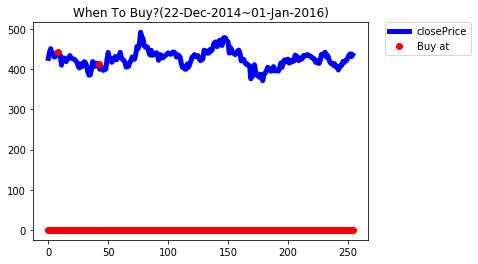

In [21]:
def getStockDataJson(reader):
    stocks = []
    count = 0
    for line in reader:
        count += 1
        stock = {}
        stockDate = line[0]
        stockClosing = line[1]
        stock["Date"] = stockDate
        stock["Close"] = stockClosing
        stocks.append(stock)
#         if count > test_set_len:
#             break
    return stocks
        
fileReadPred = open("Final/Pred_set_"+symbol+".csv")
readerPred = csv.reader(fileReadPred)
stock_data = getStockDataJson(readerPred)

close_line= np.zeros(len(stock_data), dtype=np.float)
for x in range(0,len(stock_data)):
    close_line[x]=float(stock_data[x].get("Close"))

#draw pic
plt.figure()
print(stock_data)
new_buy= np.zeros(min(len(close_line),len(rst_arr)), dtype=np.float)
print("Length rst:",len(rst_arr))
print("Length close:",len(close_line))
print(close_line)
for i in range(0,min(len(rst_arr),len(close_line))):
    new_buy[i]=rst_arr[i]*close_line[i]
print("new buy:",new_buy,"Length:",len(new_buy))
plt.plot(close_line[:min(len(rst_arr),len(close_line))],label='closePrice',linewidth=5,color=[0,0,1])
plt.plot(new_buy, 'ro',label='Buy at',linewidth=1,color=[1,0,0])
plt.title("When To Buy?("+stock_data[0].get("Date")+"~"+stock_data[min(len(rst_arr),len(close_line))].get("Date")+")")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("CNNRecommendedImage/"+symbol+".jpg")
plt.show()